Accuracy: 0.83
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

3-Fold Cross-Validation scores: [0.5        1.         0.66666667]
Mean CV score: 0.7222222222222222
Standard Deviation of CV scores: 0.20786985482077452


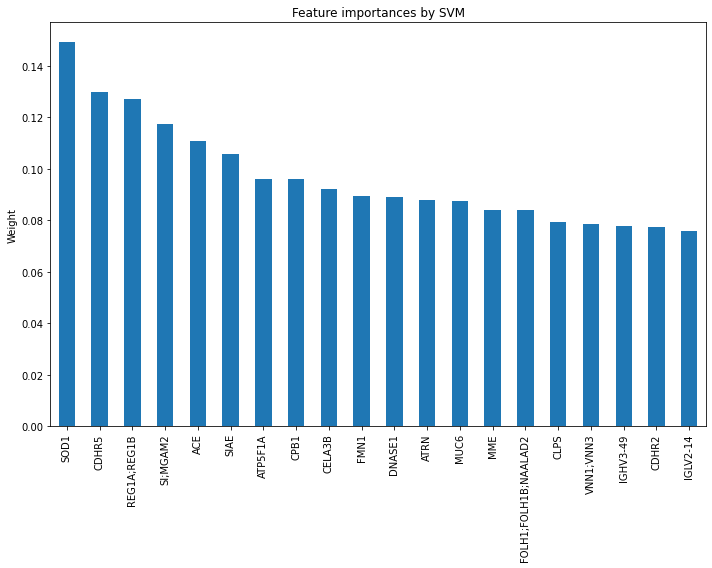

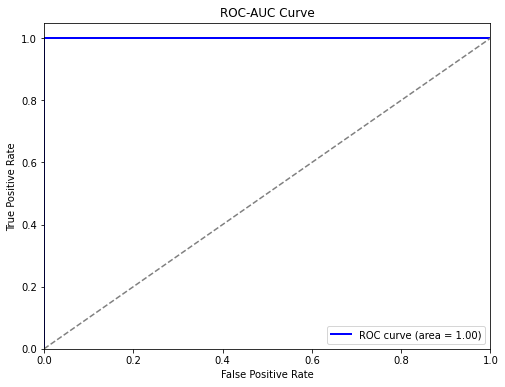

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from matplotlib import pyplot as plt

# Load the dataset and prepare data
df = pd.read_excel('Presentation - omics challenge Data.xlsx', index_col=0, header=1)
target = df['Label']
df = df.drop(['Label'], axis=1)
df_amino = df.iloc[:, 0:21]
df_prot = df.iloc[:, 21:]

# Scaling using MinMaxScaler
scaler = MinMaxScaler()
df_amino_scaled = pd.DataFrame(scaler.fit_transform(df_amino), columns=df_amino.columns, index=df.index)
df_prot_scaled = pd.DataFrame(scaler.fit_transform(df_prot), columns=df_prot.columns, index=df.index)

# Combine scaled data
df_combined = pd.concat([df_amino_scaled, df_prot_scaled], axis=1)

# Encode the labels to binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)  # 'Control' becomes 0, 'CRC' becomes 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_combined, y_encoded, stratify=y_encoded, random_state=42)

# Train SVM with linear kernel
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Function to plot feature importances
def f_importances(feat, n):
    sorted_features = feat.sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 8))
    sorted_features[0:n].plot.bar(ax=ax)
    ax.set_title("Feature importances by SVM")
    ax.set_ylabel("Weight")
    fig.tight_layout()

# Extract feature importances using the SVM coefficients
feat_imp = pd.Series(svm_model.coef_[0], index=df_combined.columns)

# Plot top 20 important features
f_importances(feat_imp, 20)

# Evaluate the model
y_pred = svm_model.predict(X_test)

# Print accuracy and classification report
print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# k-Fold Cross-Validation
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=kf, scoring='accuracy')

print(f'{k}-Fold Cross-Validation scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Standard Deviation of CV scores:', cv_scores.std())

# ROC-AUC Curve (on the test set)
y_pred_proba = svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()
